In [1]:
import torch as tr 

import numpy as np 
import matplotlib.pyplot as plt

# Likelihood-free inference/ Simulation based inference 

We consider here statistical inference of paramters $\theta \in \mathbb{R}^d$ of a simulation-based statistical model for observed data $x_0$. A simulation based model is a paramterized data generating process, that is some function that obtains as input the paramter $\theta$ and produces as output an data point $x$ stochastically. This implicitly defines a family of probability density functions of unkonwn analtytical form.

There is one traditional method to perform lieklihood-free inference, using the discrepancy between observed data $x_0$ and data $x$ simulated with paramter $\theta$. If this discrepancy is small, we should assign higher porbability mass to the $\theta$ as if it is high. This is called *Approximate Bayesian Computation(ABC)** and we distinguish two methods: 
* **Simulation based methods:** Hereapproximately sample from the posterior for which we assign high probability mass at paramters that produce data throught the simulator that is similar to observations.
* **Synthetic likelihood approaches**: We try to approximate the likelihood functions. Given a likelihood and prior we obtain the posterior by Bayes Theorem or approximate it with various other methods of Bayesian inference.


## 1) Approximate Bayesian Computation (ABC)

In general ABC methods draw approximate samples from the paramters posterior by repeatedly simulating the model and checking wheather simulated and observed data match. Let $B_\epsilon(x)$ be a neighborhood of $x_0$ defined as the set of datapoints whose distance from $x_0$ is no more then $\epsilon$, that is $B_\epsilon(x_0) = \{x| ||x-x_0||< \epsilon\}$. Here $|| \cdot ||$ is any norm in $\mathbb{R}^D$. For a small $\epsilon$ we can approximate the likelihood $p(x_0|\theta)$ by the averaged conditional density in $B_\epsilon(x_0)$:
$$ p(x_0|\theta) \approx \frac{P(||x-x_0|| \leq \epsilon \mid \theta )}{|B_\epsilon(x_0)|}$$
where $|B_\epsilon(x_0)|$ is the volume of the epsilon ball. Substituting this likelihood into Bayes theorem we obtain
$$ p(\theta |x=x_0) \approx \frac{P(||x-x_0|| \leq \epsilon\mid \theta)p(\theta)}{\int P(||x-x_0|| \leq \epsilon\mid \theta')p(\theta')d\theta'} = p(\theta \mid \ || x- x_0|| \leq \epsilon)$$
The approximate posterior $p(\theta \mid ||x-x_0|| \leq \epsilon)$ approaches the exact posterior as $\epsilon \rightarrow 0$. Problematically if $\epsilon \rightarrow 0$ the probability that a random sample $x$ falls int $B_\epsilon(x_0)$ also approaches zero. Hence we must choose a tradeoff between accuracy and computational costs.

### 1.1) Simulation based: Rejection ABC

One of the simplest algorithms is **Rejection ABC**, which is a rejections-sampling method for obtaining independent samples from the approximate posterior $p(\theta\mid \ || x -x_0||\leq \epsilon)$. It works by first sampling paramters from the prior $p(\theta)$, then simulating the model using the sampled paramters and only accepting the sample if the simulated data is no further away from $x_0$ than $\epsilon$.


As example we consider a simple Gaussian model
$$ p(x|\mu) = \mathcal{N}(x; \mu, I) \quad \text{with prior} \quad p(\mu) = \mathcal{N}(\mu; 0,I)$$
Here we clearly have a likelihood available, but lets still consider a simulation based model. Given the paramter $\mu$ we can simulate from this process $x = \mu + s$ with $s \sim \mathcal{N}(s;0,I)$. We can compare this to the exact posterior, which is given by
$$ p(\mu|x=x_0) \propto p(x=x_0|\mu)p(\mu) \propto \exp(-\frac{1}{2} \left((\mu-x_0)^T(\mu-x_0) + \mu^T\mu \right) \propto \mathcal{N}(\mu; \frac{x_0}{2}, I) $$

So lets write a simulation based model. 

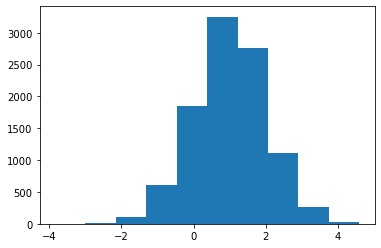

In [2]:
def simulator(mu):
    return mu + tr.randn(mu.shape)
# Simulate normal distribution with mean 1
_ = plt.hist(simulator(tr.ones(10000, 1)).T)

Lets also write a rejection ABC method for inference. We will investigate $x_0 = (1, 1, \dots, 1) \in \mathbb{R}^d$.

In [3]:
def dist(x,y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    dist = tr.pow(x - y, 2).sum(2) 
    return dist

In [4]:
def rejection_ABC(x_0, simulator, prior, epsilon=0.1, N_prop=1000000):
    samples = prior.sample_n(N_prop)
    x_sim = simulator(samples)
    mask = (dist(x_sim, x_0) < epsilon)[:,0]
    accepted = samples[mask]
    print("Acceptance ratio: ", accepted.size(0)/N_prop)
    return accepted

In [5]:
D = 2
x_0 = tr.ones(D)
prior = tr.distributions.MultivariateNormal(tr.zeros(D), tr.eye(D))
post_samples = rejection_ABC(x_0, simulator, prior, epsilon=0.1)
print("Expected value of mu: ", post_samples.mean(axis=0))

Acceptance ratio:  0.015066
Expected value of mu:  tensor([0.4907, 0.4955])


In [6]:
D = 5
x_0 = tr.ones(D)
prior = tr.distributions.MultivariateNormal(tr.zeros(D), tr.eye(D))
post_samples = rejection_ABC(x_0, simulator, prior, epsilon=0.1)
print("Expected value of mu: ", post_samples.mean(axis=0))

Acceptance ratio:  7e-06
Expected value of mu:  tensor([0.7391, 0.0687, 0.4973, 0.0537, 0.4546])


Here we see the problem with rejection ABC! It scales realy bad with dimension. In fact the acceptance probability drops at a rate of $\epsilon^D$. Hence we cannot afort higher dimensional observations.

In practise, in order to maintain a suitable acceptance probability, we typically transform the data into a small number of summary statistics in order to reduce the dimensionality $D$. If the summary statistics are sufficient, then turning data into summary statistics incurs no loss of informations. For example in our case we can use the mean as sufficient staistic!

In [7]:
def rejection_ABC_mean(x_0, simulator, prior, epsilon=0.1, N_prop=1000000):
    s_0 = x_0.mean().reshape(1,)
    samples = prior.sample_n(N_prop)
    x_sim = simulator(samples)
    s_sim = x_sim.mean(1).reshape(N_prop,1)
    mask = (dist(s_sim, s_0) < epsilon)[:,0]
    accepted = samples[mask]
    print("Acceptance ratio: ", accepted.size(0)/N_prop)
    return accepted

In [8]:
D = 2
x_0 = tr.ones(D)
prior = tr.distributions.MultivariateNormal(tr.zeros(D), tr.eye(D))
post_samples = rejection_ABC_mean(x_0, simulator, prior, epsilon=0.1)
print("Expected value of mu: ", post_samples.mean(axis=0))

Acceptance ratio:  0.153107
Expected value of mu:  tensor([0.4832, 0.4798])


In [9]:
D = 5
x_0 = tr.ones(D)
prior = tr.distributions.MultivariateNormal(tr.zeros(D), tr.eye(D))
post_samples = rejection_ABC_mean(x_0, simulator, prior, epsilon=0.1)
print("Expected value of mu: ", post_samples.mean(axis=0))

Acceptance ratio:  0.121497
Expected value of mu:  tensor([0.4593, 0.4608, 0.4597, 0.4596, 0.4598])


As we observe with this approach we retain a relatively high acceptance probability also in high dimensions.

Nevertheless often it is hard to find usefull summary statistics. There are several more advanced methods using e.g. MCMC rather then rejection sampling.

### 1.2) Paramteric synthetic likelihood approaches

The pdf of the likelihood $p(x|\theta)$ is unknown but it may be reasonably to assume that it belongs to a certain paramteric family. For instance, if we use summary statistics $\phi$ via averaging, then the central limit theorem suggest that $p(\phi|\theta)$ may be Gaussian if the number of samples $n$ is sufficiently large.
$$ p(\phi|\theta) \approx \mathcal{N}(\phi; \mu_\theta, \Sigma_\theta) = \frac{1}{(2\pi)^d |\det\Sigma_\theta|^{1/2}} \exp\left( (\phi-\mu_\theta)\Sigma_\theta^{-1}(\phi-\mu_\theta)\right)$$
The log likelihood function for an observation $\phi_0$ is thus given by 
$$ l_s(\theta) = -\frac{d}{2}\log(2\pi) - \frac{1}{2}\log |\det \Sigma_\theta |  - \frac{1}{2}(\phi_0-\mu_\theta)^T\Sigma_{\theta}^{-1}(\phi_0 - \mu_\theta)$$
The mean $\mu_\theta$ and covariance matrix $\Sigma_\theta$ a generally unknown, but the simulator can be used to given an Monta Carlo estimate by
$$ \mu_\theta \approx \frac{1}{N}\sum_{i=1}^N \phi_{\theta}^{(i)} \qquad \Sigma_\theta \approx \frac{1}{N} \sum_{i=1}^N (\phi_\theta^{i} - \mu_\theta)(\phi_\theta^{i} - \mu_\theta)^T)$$
The synthetic likelihood as we construct will be a stochastic process a.k.a a random function. Lets consider this for the previous example of estimateing the mean of a normal distribution. The sample average is a suffiecient statistic for this task. Hence given some observations $x_0 = (x_0^{(1)}, \dots, x_0^{(n)})$, we reduce the observations and simulated ata $x_0$ and $x_\theta$ to their empirical means 
$$ \phi_0 = \frac{1}{n}\sum_{i=1}^n x_n^{(i)}\qquad \phi_\theta = \frac{1}{n}\sum_{i=1}^n \sum_{i=1}^n y_\theta^{(i)}$$

In [10]:
D=1
n = 10
x_0 = tr.ones(n,D) + tr.randn(n,D)

phi_0 = x_0.mean(axis=0)
phi_0

tensor([0.3460])

In this special case the distribution of summary statistics $\phi_\theta$ is known, $\phi_\theta \sim \mathcal{N}(\theta, \frac{1}{n})$. Hence instead of estimating it by samples we use the true variance, we have $l_s(\theta) = -1/2 \log (2\pi/n)-n/2(\phi_0 - \mu_\theta)**2$. Since $\mu_\theta$ is an average of $N$ realizations of $\phi_\theta$ we obtain $\mu_{\theta} \sim \mathcal{N}(0, 1/(nN))$ and we can write the synthetic likelihood as 
$$ l_s(\theta) = -\frac{1}{2} \log \left( \frac{2\pi}{n}\right) - \frac{n}{2}(\phi_0 - \theta-g)^2 \quad \text{with} \quad g \sim \mathcal{N}(0, \frac{1}{nN})$$
Luckily we can evaluate the mean and variance of the stochastic process analytically.
$$ E[l_s(\theta)] = -\frac{1}{2} \log \left( \frac{2\pi}{n}\right) - \frac{n}{2}E[(\phi_0 - \theta-g)^2] = -\frac{1}{2} \log \left( \frac{2\pi}{n}\right) - \frac{n}{2}E[(\phi_0 - \theta)^2 - 2(\phi_0-\theta)E[g] - E[g^2] = -\frac{1}{2} \log \left( \frac{2\pi}{n}\right) - \frac{n}{2}(\phi_0 - \theta)^2 + \frac{1}{nN}$$
$$ Var(l_s(\theta)) = \frac{n^2}{4} Var((\phi_0-\theta-g)^2) =  \frac{n^2}{4}( 4(\phi_0-\theta)^2)Var(g) + Var(g^2)) = \frac{n(\phi_0-\theta)^2}{N} + \frac{1}{2N^2}$$

In [11]:
thetas = tr.linspace(-1,3,200)
N = 20
pi = tr.tensor(tr.acos(tr.zeros(1)).item() * 2)
l_mean = -0.5*tr.log(pi/n) - n/2*((phi_0 - thetas)**2 + 1/(n*N))
l_samples = -0.5*tr.log(pi/n) - n/2*(phi_0 - thetas- tr.randn(200)/np.sqrt(n*N))**2
l_var = n*(phi_0 - thetas)**2/N + 0.5*(1/N**2)

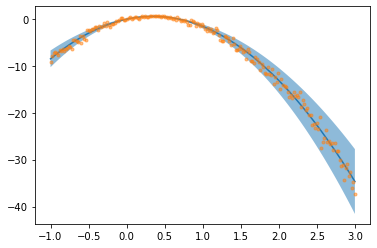

In [12]:
plt.plot(thetas, l_mean)
plt.plot(thetas, l_samples, ".", alpha=0.5)
plt.fill_between(thetas, l_mean-1.96*l_var, l_mean+1.96*l_var, alpha=0.5)

We see that the most likely paramter value is at $\phi_0$. However in more complex model we have to simulate the stochastic process which makes the synthetic likelihood not smooth. Further gradient-based optimization becomes tricky beacuse the funcional form the likelihood is unknown.

Similarly but in a non paramteric fashion we could use **kernel density estimates** to construct a synthetic likelihood that is not bound to some paramteric family.

### 1.3) Nonparamteric sysnthetic likelihood approaches

An alternative to assuming a parametric model of the summary statistics we can approximate the likelihood using a kernel density estimate.
$$ p(\phi|\theta) \approx \mathbb{E}[k(\phi, \phi_\theta)]$$
where $k$ is a suitable kernel. We can approximate it emprically by
$$ \mathbb{E}[K(\phi, \phi_\theta)] = \frac{1}{N}\sum_{i=1}^N K(\phi,\phi_\theta^{(i)}) \qquad \phi_\theta^{(i)} \sim p(\phi|\theta)$$
We hence can approximate the likelihood function as $l_k(\theta) = \mathbb{E}[K(\phi_0, \phi_\theta)]$ or writing it in temrs of the discrepancy $\Delta_\theta = ||\phi_0-\phi_\theta||$ as 
$$ l_k(\theta) = \mathbb{E}[k(\Delta_\theta)]$$
which requires that $k$ is stationary kernel. For a convex kernel we obtain by Jensens inequality a simple lower bound 
$$ l_k(\theta) \geq k(J(\theta)) \quad \text{ with } J(\theta) = \mathbb{E}[\Delta_\theta]$$
Since the kernel is maximized at $0$, the lower bound is maximized by minimizing the expectation over the discrepancy $J(\theta)$. A simple choice is given by the uniform kernel $k(u) = c \cdot I(u \in [0,h])$, hence clearly $l_k(\theta) = c \cdot P(\Delta_\theta < h)$. The kernel is not convex, however we can still obtain a lower bound by Marcovs inequality.
$$ l_k(\theta) = c(1-P(\Delta_\theta \geq h)) \geq c(1-\frac{1}{h}\mathbb{E}[\Delta_\theta])$$
This is nice as it does not involve any rejections! Previously we only consider $\Delta_\theta < h$, hence reject most of the samples...

Lets again consdier the problem to estimate the mean of a Gaussian. We can use the discrepancy $\Delta_\theta$ between the emprical observed and simulate means $x_0$ and $x_\theta$ e.g $\Delta_\theta = (x_\theta - x_0)^2$. Because of the use of simulated data the discrepany is a stochastic process. For this simple model we can evaluate the likelihood $l_k(\theta) = c\cdot P(\Delta_\theta < h))$ in closed form
$$ l_k(\theta) = F(\sqrt{n}(\theta_0-\theta) + \sqrt{nh}) - F(\sqrt{n}(\phi_0 - \theta)- \sqrt{nh})$$
where $F$ is the cummulative distriution function of a standard normal.

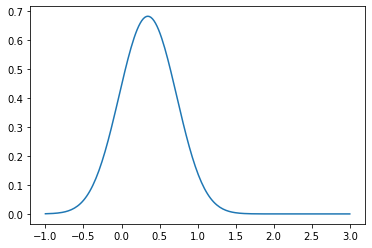

In [13]:
p_normal = tr.distributions.Normal(0,1)
h = 0.1
l = p_normal.cdf(np.sqrt(n)*(phi_0 - thetas) + np.sqrt(n*h)) - p_normal.cdf(np.sqrt(n)*(phi_0 - thetas)-np.sqrt(n*h) )
plt.plot(thetas,l)

## 2) Regression based approaches

As we saw standard approaches for approximate synthetic lilelihood relies on sample averages or simplistic model assumptions, mostly to compute intractable expectations. However sample averages are not the only way to approximate these, it is also possible to interpret these as regression problem as we may already saw in the kernel based solutions we can minimize a lower bound
$$ J(\theta) = \mathbb{E}[\Delta_\theta]$$
which we can interpret as regression problem for learning $J$. Infering $J(\theta)$ via regression requires training data in the form of tuples $(\theta^{i}, \Delta_\theta^{(i)})$. Since we are mostly interested in regions where $\Delta_\theta$ is small, we may actively try to construct the training data such that they are more densly clustered around the minimize of $J(\theta)$. As $J(\theta)$ is nknown we need to perform regression and optimization at the same time. Given an initial guess for the minimizer, we can sample some evidence $E^{(t)} = \{(\theta^{(1)}, \Delta_\theta^{(1)}), \dots, (\theta^{(t)}, \Delta_\theta^{(t)})\}$ and use this to estimate $J$ via regression.

Combining regression with the acquisition of new evidence in order to minimize and objective is known as Bayesian optimization. The objective $f$ is often modeled as Gaussian process $f \sim GP(m,k)$ with mean function $m(\theta)$ and kernel $k(\theta,\theta') subject tot Gaussian noise with variance $\sigma_n^2$. The joint distribution of $f$ at $t$ points $\theta^{(1)}, \dots, \theta^{(t)}$ is thus given by 

$$ \begin{pmatrix} f^{(1)}\\\vdots \\ f^{(t)} \end{pmatrix} \sim \mathcal{N}\left( \begin{pmatrix}m(\theta^{(1)})\\\vdots \\ m(\theta^{(t)}) \end{pmatrix}; \begin{pmatrix} k(\theta^{(1)}, \theta^{(1)}) & \dots & k(\theta^{(1)},\theta^{(t)})\\ \vdots && \vdots \\ k(\theta^{(t)}, \theta^{(1)}) & \dots & k(\theta^{(t)}, \theta^{(t)})\end{pmatrix} + \sigma^2 I \right)  $$

Given evidence $E^{(t)}$ the posterior $p(f|E) = \mathcal{N}(\mu_t(\theta), v_t(\theta) + \sigma^2)$ with 
$$ \mu_t(\theta) = m(\theta) + k_t(\theta)^TK_t^{-1}(f_t-m_t) \quad v_t(\theta) = k(\theta, \theta) - k_t(\theta)^TK_t^{-1}k_t(\theta)$$
The evidence set can be augmented by selecting a new point $\theta^{(t+1)}$ where $f$ is next evaluated. The point is choosen based on the posterior distribution. One possible acquisition function $A_t(\theta)$ can be 
$$ A_t(\theta) = \mu_t(\theta) - \sqrt{v_t(\theta)}$$
Classically $\theta^{(t+1)}$ is choosen as the minimizer of $A_t(\theta)$. 

In [28]:
from numpy.random import randn, multivariate_normal
from numpy.linalg import cholesky, solve
from scipy.linalg import cho_solve, cho_factor, toeplitz
import numpy as np

def m(x):
    return 0.0


def kernel(X1, X2, l=1, sigma_f=1.0):
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def GP_reg(X,Y,x,m, k, lam=1):
    out = {}
    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)
    x = np.array(x).reshape(-1,1)
    N = X.shape[0]

    mX = m(X)
    kXX = k(X,X)
    G = kXX + lam**2 * np.eye(N)

    G = cho_factor(G)
    kxx = k(x,x)
    kxX = k(x,X)
    A = cho_solve(G, kxX.T).T

    out["mpost"] = (m(x) + A @ (Y - mX))[:,0]  # mean
    out["vpost"] = kxx - A @ kxX.T  # covariance
    out["stdpo"] = np.sqrt(np.diag(out["vpost"]))

    return out

In [15]:
def simulator(mu):
    return mu + np.random.randn(*mu.shape)

In [16]:
def A(out, beta=2):
    return out["mpost"] - beta*out["stdpo"]

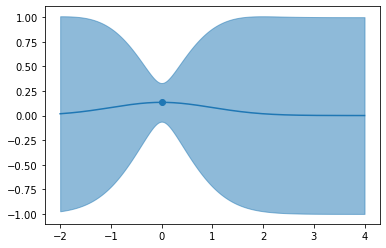

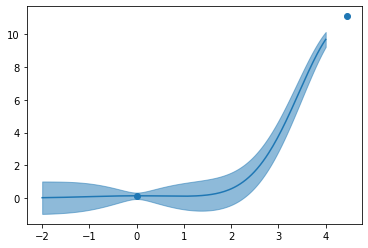

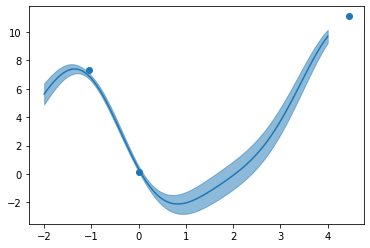

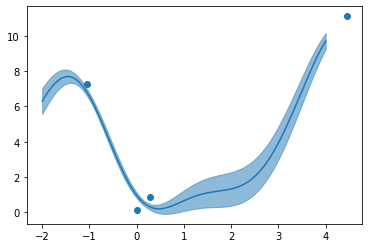

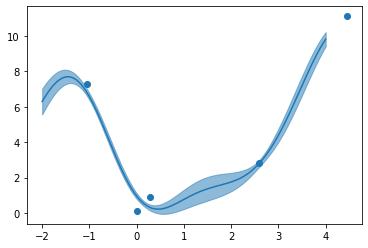

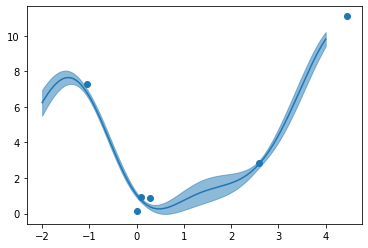

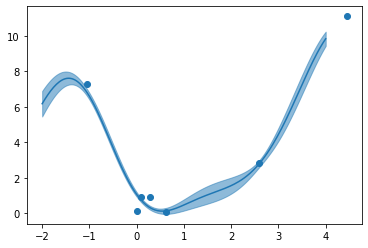

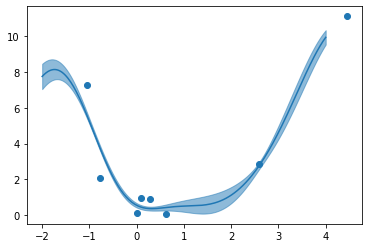

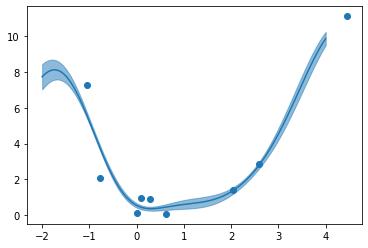

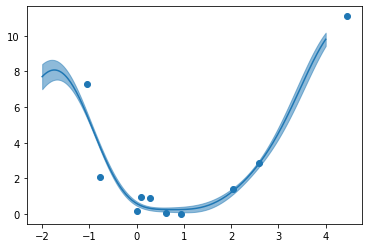

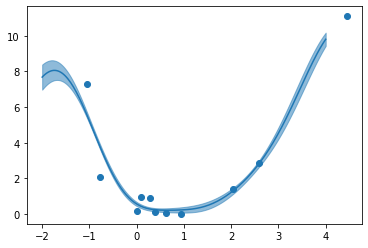

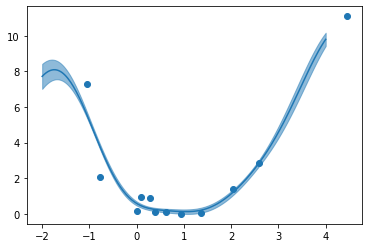

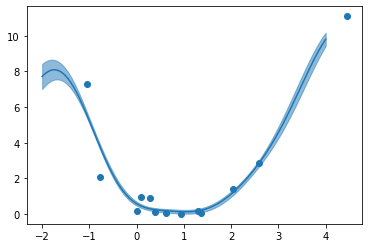

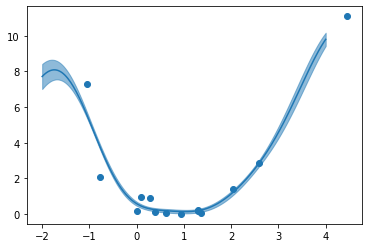

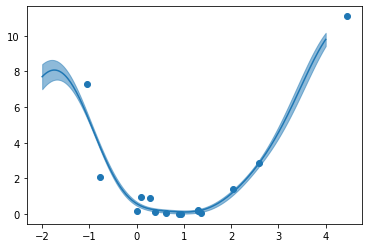

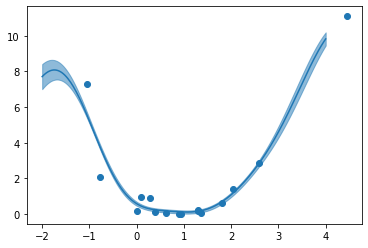

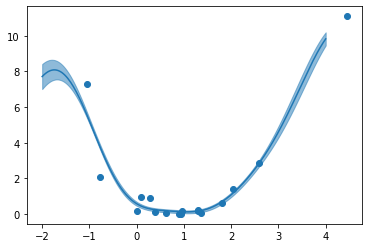

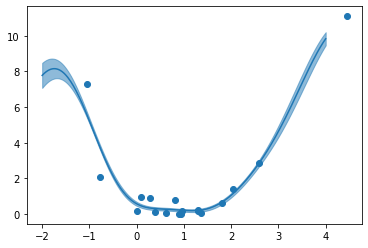

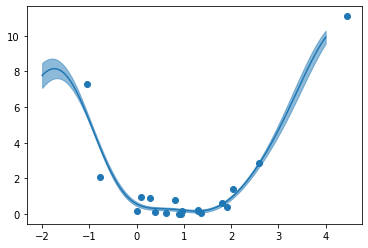

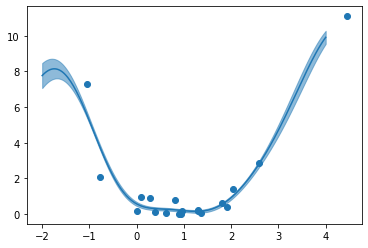

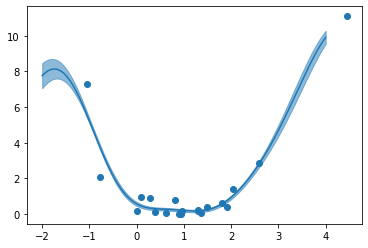

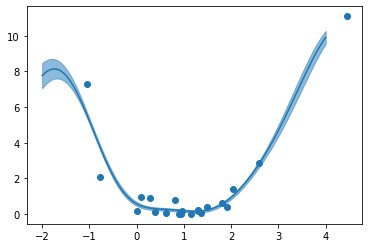

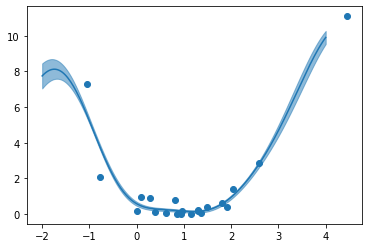

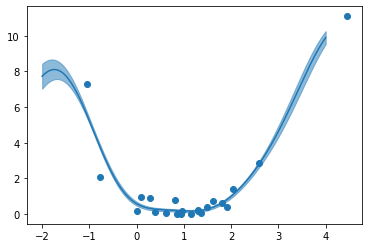

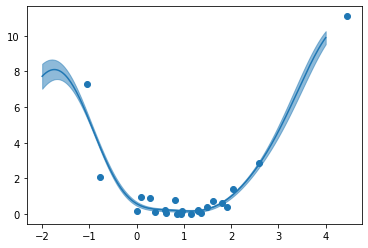

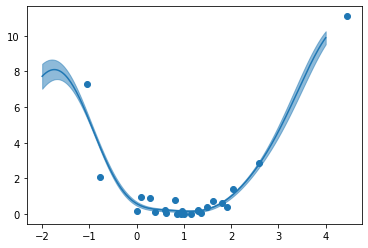

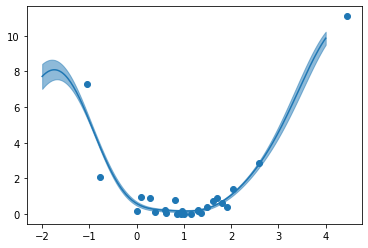

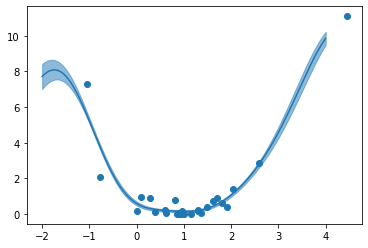

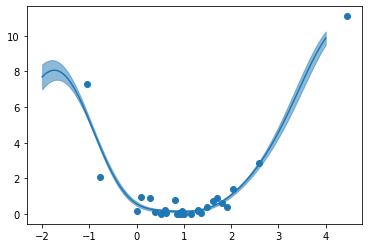

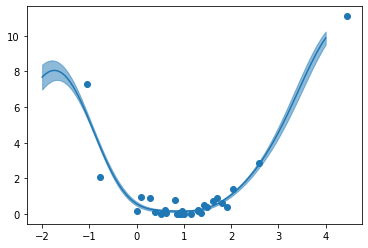

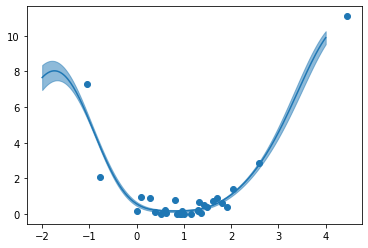

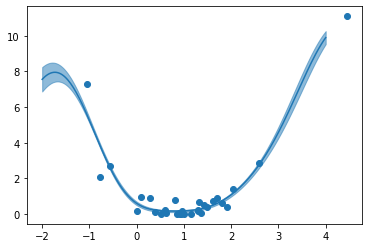

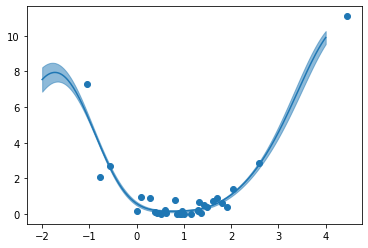

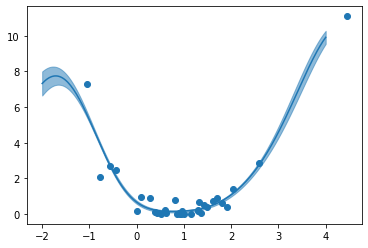

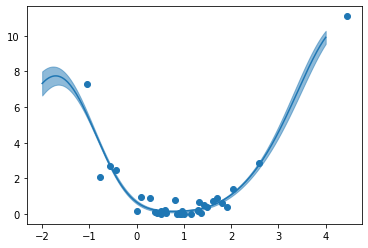

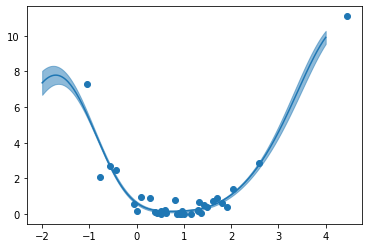

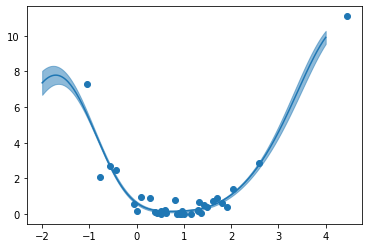

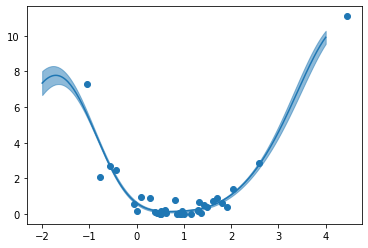

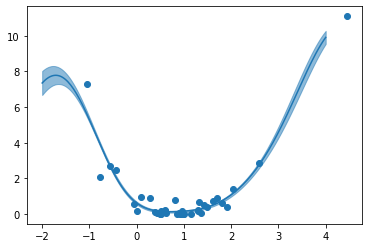

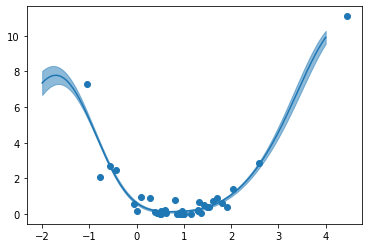

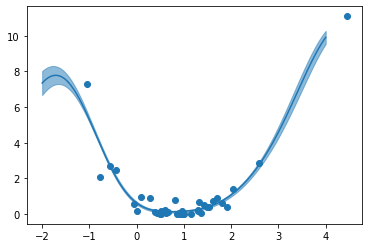

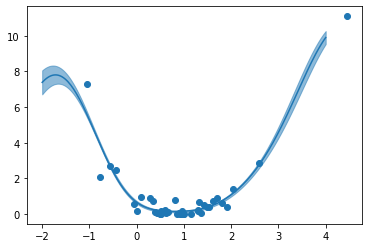

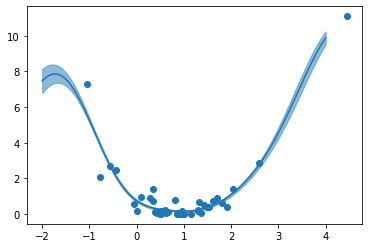

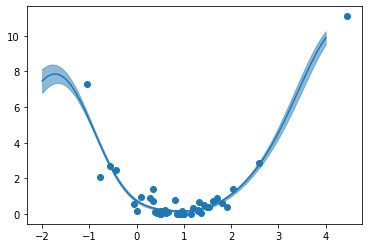

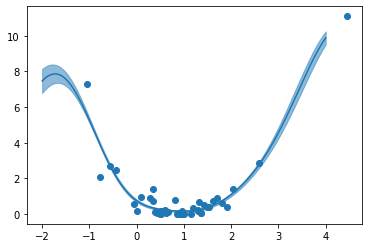

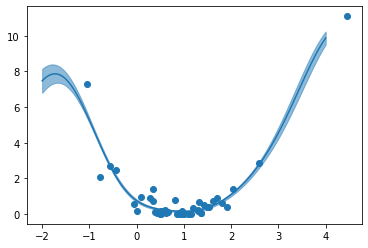

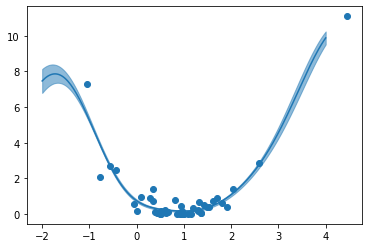

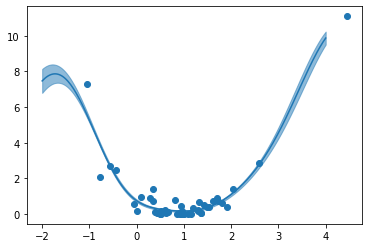

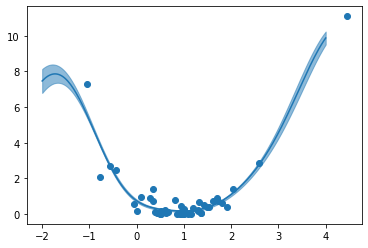

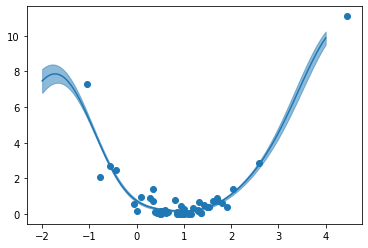

In [29]:
itr = 50
thetas = np.linspace(-2,4,200)
theta_s = [0]
deltaY = [simulator(np.zeros(100)).mean()]
phi_0 = 1

for i in range(itr):
    out = GP_reg(theta_s, deltaY, thetas,m,kernel, lam=0.2)
    # Plot
    if i % 1 == 0:
        plt.scatter(theta_s,deltaY)
        plt.plot(thetas,out["mpost"])
        plt.fill_between(thetas,out["mpost"].flatten()-out["stdpo"].flatten(), out["mpost"].flatten()+out["stdpo"].flatten(), alpha=0.5, color="C0")
        plt.show()
    # Aquire new point
    a = A(out)
    new_theta = thetas[np.argmin(a)] + 0.5*np.random.randn() # Stochasticly choose minimizer
    newY = simulator(new_theta.repeat(10)).mean()
    newdeltaY = (phi_0 - newY)**2
    theta_s.append(new_theta)
    deltaY.append(newdeltaY)



## Sources 

* Gutmann, M. U., & Corander, J. (2016). Bayesian optimization for likelihood-free inference of simulator-based statistical models. Journal of Machine Learning Research.